In [ ]:
# !pip install tensorflow==1.15

In [ ]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
DATA_PATH = '/content/valve1/'

In [ ]:
fi = os.listdir(DATA_PATH)

In [ ]:
valve1_data = [pd.read_csv(os.path.join(DATA_PATH, file), sep=';', parse_dates=True) for file in fi]

In [ ]:
df = valve1_data[0]
df.datetime = 0
for i in (1, len(valve1_data)-1):
    valve1_data[i].datetime = i
    df = pd.concat([df, valve1_data[i]])

In [ ]:
df.to_csv('check.csv', index=False)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

# Data Loading

In [81]:
check = np.array([[1,2,3], [4,5,6]])
check * 3

array([[ 3,  6,  9],
       [12, 15, 18]])

In [82]:
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.

Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)

-----------------------------

data_loading.py

(0) MinMaxScaler: Min Max normalizer
(1) sine_data_generation: Generate sine dataset
(2) real_data_loading: Load and preprocess real data
  - stock_data: https://finance.yahoo.com/quote/GOOG/history?p=GOOG
  - energy_data: http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
"""

## Necessary Packages
import numpy as np



class MinMaxScalerClass():
  def __init__(self, eps = 1e-7):
    self.eps = eps

  def fit_transform(self, data):
    self.min = np.min(data,0)
    self.max = np.max(data,0)
    self.data = data
    numerator = self.data - self.min
    denominator = self.max - self.min
    norm_data = numerator / (denominator + self.eps)
    return norm_data

  def inverse_transform(self, data):
    return data * (self.max - self.min + self.eps) + self.min

def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data


def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data
    

def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  ori_data = np.loadtxt(data_name, delimiter=",", skiprows=1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data

In [ ]:
data_name = 'check.csv'
seq_len = 24

ori_data = real_data_loading(data_name, seq_len)
print(data_name + ' dataset is ready.')

check.csv dataset is ready.


In [ ]:
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128

In [ ]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


In [76]:
from sklearn.preprocessing import MinMaxScaler as mms

In [91]:
generated_data.shape

(3419, 24, 11)

In [89]:
check = scaler.inverse_transform(generated_data)

ValueError: ignored

In [84]:
scaler = MinMaxScalerClass()
scaler.fit_transform()

In [95]:
generated_data

array([[[5.25649484e-02, 8.12819832e-01, 2.82980327e-01, ...,
         1.29299488e-01, 9.99999781e-01, 3.30805745e-06],
        [2.84831224e-02, 9.05662388e-01, 4.28725952e-01, ...,
         4.62441075e-01, 9.99999304e-01, 1.60932525e-06],
        [4.29214832e-02, 8.13736584e-01, 4.90981404e-01, ...,
         5.39514945e-01, 9.99999304e-01, 6.25461277e-04],
        ...,
        [7.33021493e-02, 7.67672804e-01, 4.34050471e-01, ...,
         7.85043458e-01, 9.99998589e-01, 4.17232472e-07],
        [8.92437094e-02, 7.39800177e-01, 4.22549213e-01, ...,
         5.53759442e-01, 9.99999542e-01, 0.00000000e+00],
        [7.26951654e-02, 7.99011575e-01, 4.33337726e-01, ...,
         6.66828258e-01, 9.99999542e-01, 6.55651027e-07]],

       [[7.40638072e-02, 7.53372049e-01, 4.90373443e-01, ...,
         7.58454602e-01, 0.00000000e+00, 0.00000000e+00],
        [7.15773101e-02, 5.08160061e-01, 4.41090366e-01, ...,
         7.44336884e-01, 2.08616236e-07, 0.00000000e+00],
        [6.55727382e-02, 

array([[7.88474227e-01, 2.82826677e-02, 4.05706007e-02, ...,
        2.95170169e+01, 9.99999781e-01, 3.30805745e-06],
       [4.27246836e-01, 2.85944237e-02, 4.20449489e-02, ...,
        3.08491169e+01, 9.99999304e-01, 1.60932525e-06],
       [6.43822248e-01, 2.82857461e-02, 4.26747188e-02, ...,
        3.11573045e+01, 9.99999304e-01, 6.25461277e-04],
       ...,
       [1.11230671e+00, 2.77517220e-02, 4.25891082e-02, ...,
        3.19285596e+01, 1.78813916e-07, 0.00000000e+00],
       [1.09469979e+00, 2.81564557e-02, 4.20679378e-02, ...,
        3.19862390e+01, 8.94069582e-08, 0.00000000e+00],
       [1.15102618e+00, 2.82699380e-02, 4.12839722e-02, ...,
        3.19788742e+01, 8.94069582e-08, 0.00000000e+00]])

In [106]:
with open('test.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(generated_data.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in generated_data:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.2f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')

In [101]:
pd.DataFrame(scaler.inverse_transform(generated_data.reshape(-1, 11)))

,0,1,2,3,4,5,6,7,8,9,10
0,0.788474,0.028283,0.040571,0.388229,-0.448193,69.596116,24.923687,208.370857,29.517017,9.999998e-01,0.000003
1,0.427247,0.028594,0.042045,0.388229,-0.278181,68.413305,24.798171,214.200676,30.849117,9.999993e-01,0.000002
2,0.643822,0.028286,0.042675,0.388306,-0.128497,68.521710,24.797265,223.848262,31.157304,9.999993e-01,0.000625
3,0.494669,0.028524,0.042098,0.445744,0.059493,67.999582,24.812459,236.155364,32.974523,9.999574e-01,0.000017
4,0.570174,0.028510,0.042942,0.426734,-0.312280,68.186204,24.818323,220.583608,32.524543,9.999919e-01,0.000018
...,...,...,...,...,...,...,...,...,...,...,...
82051,1.238291,0.028326,0.040681,0.388264,0.057510,67.933229,24.753300,234.186956,31.998493,1.490116e-07,0.000000
82052,1.115702,0.028223,0.041933,0.388257,0.066949,67.911021,24.749942,236.385071,31.984333,8.940696e-08,0.000000
82053,1.112307,0.027752,0.042589,0.388229,0.250360,67.920810,24.749026,232.456983,31.928560,1.788139e-07,0.000000
82054,1.094700,0.028156,0.042068,0.388236,0.215354,67.963256,24.749827,233.305111,31.986239,8.940696e-08,0.000000


In [68]:
pd.read_csv('check.csv').shape

(3443, 11)

In [69]:
from clearml import Task
task = Task.init("VKR", "ssd train_4")
print('test')
task.close()

ClearML Task: created new task id=81af20d6212d4eab8146c20817a1221c
2022-05-24 20:50:42,129 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/0f5414c429db4b37aaed93ca752cef40/experiments/81af20d6212d4eab8146c20817a1221c/output/log
test
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


ClearML Task: created new task id=3dbd3cd2b9e64734b8e675347c102b16
ClearML results page: https://app.clear.ml/projects/9105a581d4b14101b23a61c14a69434e/experiments/3dbd3cd2b9e64734b8e675347c102b16/output/log
2022-05-24 20:56:59,332 - clearml.Task - INFO - No repository found, storing script code instead


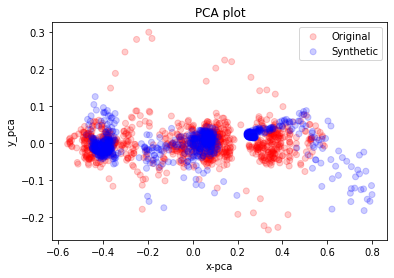

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.022730
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.674934
[t-SNE] KL divergence after 300 iterations: 1.288257


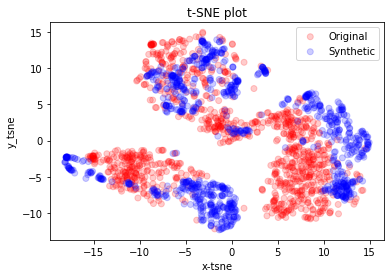

In [70]:
from clearml import Task 
task = Task.init("predict_analysis", "graph")
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')
task.close()